In [1]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Input, \
    LayerNormalization, MultiHeadAttention, Add
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
import pydicom
import cv2
import gc
import psutil
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
# from sklearn.metrics import roc_auc_score
import seaborn as sns  # For confusion matrix heatmap
import time
from tensorflow.keras.regularizers import l2
from keras.utils import to_categorical
from collections import defaultdict
import tensorflow as tf
import matplotlib.pyplot as plt  # Import matplotlib for plotting


# -------------------------- Memory Management Functions --------------------------
# Monitor GPU memory
def print_gpu_memory():
    from subprocess import check_output
    try:
        result = check_output(['nvidia-smi']).decode('utf-8')
        print(result)
    except Exception as e:
        print(f"Failed to get GPU memory info: {e}")


def print_ram_usage():
    process = psutil.Process(os.getpid())
    print(f"Current RAM usage: {process.memory_info().rss / (1024 * 1024):.2f} MB")


print_gpu_memory()


# Clear GPU memory
def clear_gpu_memory():
    from tensorflow.keras import backend as K
    K.clear_session()


def clear_ram_memory():
    gc.collect()
    print("RAM memory cleared")


def clear_memory():
    clear_gpu_memory()
    clear_ram_memory()


# -------------------------- Initial Setup --------------------------

# Check for GPU
tf.config.list_physical_devices('GPU')
print(tf.config.list_physical_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Monitor initial GPU and RAM usage
print_gpu_memory()
print_ram_usage()

# Clear memory before starting
clear_memory()

# Enable mixed precision training if supported
try:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision enabled.")
except Exception as e:
    print(f"Failed to set mixed precision: {e}")

# Clear memory after setting policies
clear_memory()
print_ram_usage()
clear_memory()
print_ram_usage()
clear_memory()
clear_memory()
print_ram_usage()



2025-06-05 22:46:59.461130: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749163619.476778    2886 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749163619.481606    2886 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749163619.494828    2886 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749163619.494841    2886 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749163619.494843    2886 computation_placer.cc:177] computation placer alr

Thu Jun  5 22:47:01 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.247.01             Driver Version: 535.247.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L40S                    Off | 00000000:34:00.0 Off |                    0 |
| N/A   32C    P8              47W / 350W |      0MiB / 46068MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
def build_simplified_coatnet_model(input_shape=(128, 128, 1)):
    inputs = Input(shape=input_shape)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    for _ in range(2):  # Simplified blocks
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = Dropout(0.2)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, x)

    model = Model(inputs=inputs, outputs=output)

    # Step 6: Compile the Model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Initialize variables to track training history
initial_training_history = None
active_learning_training_histories = []

# Create lists to store training and validation accuracy and loss
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []
initial_training_time = 0
active_learning_training_times = []
# Initialize variables to track training and validation accuracies
initial_training_accuracy = 0
active_learning_training_accuracies = []
# Initialize variables to track AUC scores
initial_auc = 0
active_learning_auc = []

In [3]:


# Set paths to your labeled and unlabeled image directories
# unlabeled_data_dir = 'D:/PHD/DSB3/stage1/stage1/used_All_Labeled22Person'
# unlabeled_csv_path = 'D:/PHD/DSB3/stage1/stage1/used_All_Labeled22Person.csv'
labeled_data_dir = 'labeled80'
unlabeled_data_dir = 'unlabeled710'
labeled_csv_path = 'labeled80.csv'
unlabeled_csv_path = 'unlabeled710.csv'
# Load labeled data from Excel files
labeled_images = []
labels = []

labeled_data = pd.read_csv(labeled_csv_path)
labeled_image_paths = [os.path.join(labeled_data_dir, row['Image_Path']) for _, row in labeled_data.iterrows()]
labels = labeled_data['label'].values
# unlabeled_csv_path = '/excel files csv/unlabeled2.csv'
unlabeled_data = pd.read_csv(unlabeled_csv_path)
unlabeled_image_paths = [os.path.join(unlabeled_data_dir, row['Image_Path']) for _, row in unlabeled_data.iterrows()]

for root, _, files in os.walk(labeled_data_dir):
    for file in files:
        if file.endswith('.dcm'):
            dicom_path = os.path.join(root, file)
            image = pydicom.dcmread(dicom_path)
            ct_image = image.pixel_array
            ct_image_resized = cv2.resize(ct_image, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
            ct_image_resized = np.expand_dims(ct_image_resized, axis=-1)
            img = tf.cast(ct_image_resized, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
            labeled_images.append(img)  # Flatten the image

X_labeled = np.array(labeled_images)
y_labeled = np.array(labels)

# Make sure the number of samples matches the number of labels
# assert len(X_labeled) == len(y_labeled), "Number of samples and labels do not match"
print('X_labeled:', len(X_labeled))
print('y_labeled:', len(y_labeled))


I0000 00:00:1749163624.780444    2886 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43629 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:34:00.0, compute capability: 8.9


X_labeled: 6080
y_labeled: 6080


In [4]:
unlabeled_images = []

for root, _, files in os.walk(unlabeled_data_dir):
    for file in files:
        if file.endswith('.dcm'):
            dicom_path = os.path.join(root, file)
            image = pydicom.dcmread(dicom_path)
            ct_image = image.pixel_array
            ct_image = image.pixel_array
            ct_image_resized = cv2.resize(ct_image, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
            ct_image_resized = np.expand_dims(ct_image_resized, axis=-1)
            img = tf.cast(ct_image_resized, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
            unlabeled_images.append(img)  # Flatten the image

X_unlabeled = np.array(unlabeled_images)
print('X_unlabeled:', len(X_unlabeled))

X_unlabeled: 23940


In [5]:
# Initialize variables to track training and validation times
initial_training_time = 0
initial_validation_time = 0  # Add this line
active_learning_training_times = []
active_learning_validation_times = []  # Add this line
X_train_labeled, X_temp, y_train_labeled, y_temp = train_test_split(
    X_labeled, y_labeled, test_size=0.3, random_state=42)  # 30% of data will be used for validation and testing

# Split the temp set into validation and test sets
X_val_labeled, X_test_labeled, y_val_labeled, y_test_labeled = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)  # 50% of temp data will be used for validation and testing

# Check the shapes to ensure the split is correct
print("Training set size:", X_train_labeled.shape)
print("Validation set size:", X_val_labeled.shape)
print("Test set size:", X_test_labeled.shape)


def dataset_to_numpy(dataset):
    features = []
    labels = []
    for x_batch, y_batch in dataset:
        features.append(x_batch.numpy())
        labels.append(y_batch.numpy())
    return np.concatenate(features), np.concatenate(labels)


# Convert data to TensorFlow dataset objects
def create_tf_dataset(X, y, batch_size, shuffle_buffer_size=1000):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset


train_dataset = create_tf_dataset(X_train_labeled, y_train_labeled, batch_size=16)
val_dataset = create_tf_dataset(X_val_labeled, y_val_labeled, batch_size=16)

# Convert TensorFlow dataset objects to NumPy arrays
X_train_labeled, y_train_labeled = dataset_to_numpy(train_dataset)
X_val_labeled, y_val_labeled = dataset_to_numpy(val_dataset)



Training set size: (4256, 128, 128, 1)
Validation set size: (912, 128, 128, 1)
Test set size: (912, 128, 128, 1)


2025-06-05 22:55:33.647899: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-05 22:55:33.782595: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321,281 (1.23 MB)

 Trainable params: 321,281 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


I0000 00:00:1749164136.418538    3139 service.cc:152] XLA service 0x7f0f7002d900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749164136.418672    3139 service.cc:160]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
2025-06-05 22:55:36.475463: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749164136.741582    3139 cuda_dnn.cc:529] Loaded cuDNN version 90701
2025-06-05 22:55:37.324271: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_977', 8 bytes spill stores, 8 bytes spill loads

2025-06-05 22:55:38.536496: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_977', 112 bytes spil

 5/67 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5538 - loss: 0.6930

I0000 00:00:1749164142.805065    3139 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


65/67 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5274 - loss: 0.6975

2025-06-05 22:55:45.762779: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_977', 12 bytes spill stores, 12 bytes spill loads

2025-06-05 22:55:46.856078: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_977', 4 bytes spill stores, 4 bytes spill loads



67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.5275 - loss: 0.6974

2025-06-05 22:55:50.899389: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_71', 4 bytes spill stores, 4 bytes spill loads



67/67 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step - accuracy: 0.5275 - loss: 0.6974 - val_accuracy: 0.4890 - val_loss: 0.6886
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5295 - loss: 0.6915 - val_accuracy: 0.5362 - val_loss: 0.6903
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5469 - loss: 0.6867 - val_accuracy: 0.5362 - val_loss: 0.6886
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5542 - loss: 0.6882 - val_accuracy: 0.5362 - val_loss: 0.6883
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5638 - loss: 0.6868 - val_accuracy: 0.5844 - val_loss: 0.6816
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5698 - loss: 0.6847 - val_accuracy: 0.5680 - val_loss: 0.6831
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5631 - loss: 0.6862 - val_accuracy: 0.5658 - val_loss: 0.6801
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5653 - loss: 0.6843 - val_accuracy: 0.5625 - val_loss: 

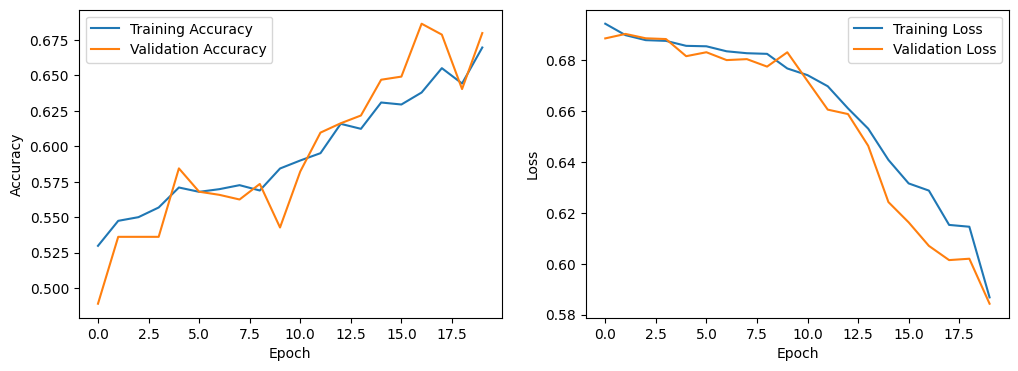

Test Accuracy: 0.672149121761322
Test Time: 0.2629399299621582
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test AUC: 0.7601504772167488
Test Precision: 0.6797385620915033
Test Recall: 0.6724137931034483
Test F1-Score: 0.6760563380281691


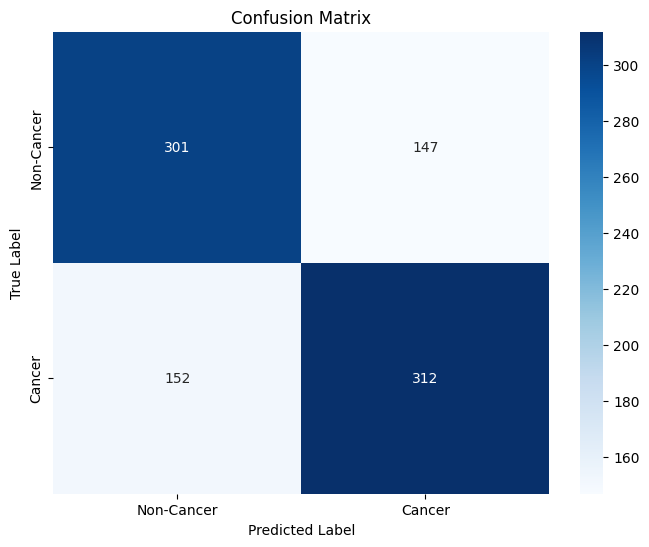

In [6]:
# ................................. Train initial model.............................................
model =  build_simplified_coatnet_model(input_shape=(128, 128, 1))
model.summary()
# Train initial model
initial_start_time = time.time()

# Train your model
history = model.fit(np.array(X_train_labeled), np.array(y_train_labeled), epochs=20, batch_size=64,
                    validation_data=(np.array(X_val_labeled), np.array(y_val_labeled)))

# Calculate the training time for the initial model
initial_training_time = time.time() - initial_start_time
# Calculate and display training accuracy for the initial model
initial_training_accuracy = model.evaluate(X_train_labeled, y_train_labeled, verbose=0)[1]
# Calculate and display validation time for the initial model
initial_start_time = time.time()
initial_validation_accuracy = model.evaluate(X_val_labeled, y_val_labeled, verbose=0)[1]
initial_validation_time = time.time() - initial_start_time
# Calculate and display AUC for the initial model
initial_predictions = model.predict(X_val_labeled)
initial_auc = roc_auc_score(y_val_labeled, initial_predictions)
print("Initial Model Training Time:", initial_training_time)
print("Initial Model Training Accuracy:", initial_training_accuracy)
print("Initial Model Validation Accuracy:", initial_validation_accuracy)
print("Initial Model Validation Time:", initial_validation_time)  # Add this line
print("Initial Model AUC:", initial_auc)

# Convert the model's predictions to binary labels (0 or 1) using a threshold (0.5 in this case)
threshold = 0.5
initial_predictions_binary = (initial_predictions > threshold).astype(int)
# Calculate and display precision for the initial model
initial_precision = precision_score(y_val_labeled, initial_predictions_binary)
# Calculate and display recall for the initial model
initial_recall = recall_score(y_val_labeled, initial_predictions_binary)
# Calculate and display F1-score for the initial model
initial_f1 = f1_score(y_val_labeled, initial_predictions_binary)
print("Initial Model Precision:", initial_precision)
print("Initial Model F1-Score:", initial_f1)
print("Initial Model Recall:", initial_recall)

# Get the training history
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()  # Display the plots

# .........................testing...................
# Evaluate the model on the test set
test_start_time = time.time()
test_accuracy = model.evaluate(X_test_labeled, y_test_labeled, verbose=0)[1]
test_time = time.time() - test_start_time
print("Test Accuracy:", test_accuracy)
print("Test Time:", test_time)

# Get predictions on the test set
test_predictions = model.predict(X_test_labeled)
test_auc = roc_auc_score(y_test_labeled, test_predictions)
print("Test AUC:", test_auc)

# Convert predictions to binary labels
test_predictions_binary = (test_predictions > threshold).astype(int)

# Calculate precision, recall, and F1-score
test_precision = precision_score(y_test_labeled, test_predictions_binary)
test_recall = recall_score(y_test_labeled, test_predictions_binary)
test_f1 = f1_score(y_test_labeled, test_predictions_binary)

print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1-Score:", test_f1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_labeled, test_predictions_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Cancer', 'Cancer'],
            yticklabels=['Non-Cancer', 'Cancer'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [7]:
#..................................start Active learning.......................
print('X_labeled:', len(X_labeled))
# -------------------------- Initial Setup --------------------------

# Monitor initial GPU and RAM usage
print_gpu_memory()
print_ram_usage()

# Clear memory before starting
clear_memory()

# Enable mixed precision training if supported
try:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision enabled.")
except Exception as e:
    print(f"Failed to set mixed precision: {e}")

# Clear memory after setting policies
clear_memory()
print_ram_usage()

print_ram_usage()
clear_memory()
clear_memory()
clear_memory()
clear_memory()
clear_memory()
print_ram_usage()
# ........................... initial variable..................................
active_learning_training_times = []
active_learning_validation_times = []
active_learning_testing_times = []
active_learning_training_accuracies = []
active_learning_auc = []
accuracy_scores = []

train_accuracy_scores = []
train_precision_scores = []
train_auc_score = []
train_recall_scores = []
train_f1_scores = []
train_roc_auc_scores = []
test_confusion_matrices = []
val_precision_scores = []
val_accuracy_scores = []
val_recall_scores = []
val_f1_scores = []
val_auc_scores = []
test_accuracy_scores = []
test_precision_scores = []
test_recall_scores = []
test_f1_scores = []
test_auc_score = []
# Active learning with Q-learning
n_queries = 120 # Number of queries (iterations)
# n_queries = 2
batch_size = 200  # Start with a batch size of 32
learning_rate = 0.1  # Learning rate for Q-learning
gamma = 0.95  # Discount factor for Q-learning
epsilon = 0.1  # Exploration rate
# Initialize Q-table
Q_table = defaultdict(lambda: np.zeros(2))  # Two possible actions: 0 and 1
# Example active learning loop
for query in range(n_queries):
    print(f"Active learning iteration {query + 1}/{n_queries}")
    clear_memory()
    clear_memory()
    print_ram_usage()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    print_gpu_memory()
    # Select samples to label
    query_start_time = time.time()
    for batch in range(0, len(X_unlabeled), batch_size):
        current_batch = X_unlabeled[batch:batch + batch_size]
        # predicted_probs = model.predict(current_batch)
        predicted_probs = model.predict(current_batch, batch_size=8)
        # num_samples_to_predict = min(batch_size, len(X_unlabeled))  # Ensure batch_size is not larger than the number of unlabeled samples
        # current_batch = X_unlabeled[:num_samples_to_predict]
        # predicted_probs = model.predict(current_batch)
        predicted_probs = np.clip(predicted_probs, 1e-10, 1.0)  # Avoid log(0) issues
        entropies = -np.sum(predicted_probs * np.log(predicted_probs), axis=1)
        kth = min(batch_size, len(entropies))  # Calculate a valid kth value
        top_indices = np.argpartition(entropies, -kth)[-kth:]  # Use the valid kth value for partitioning
        selected_indices = top_indices
        selected_images = current_batch[selected_indices]
        selected_labels = predicted_probs[selected_indices]
        # query_time = time.time() - query_start_time
        # Simulate labeling the selected samples (replace this with your actual labeling process)
        simulated_labels = np.random.randint(0, 2, size=len(selected_images))  # Simulate random labels
        selected_labels_binary = (selected_labels > 0.5).astype(int)
        # Update Q-table
        # Update Q-table
        for i, idx in enumerate(selected_indices):
            state = tuple(selected_images[i].flatten())
            action = simulated_labels[i]
            reward = 1 if simulated_labels[i] == selected_labels_binary[i] else -1
            next_state = tuple(X_unlabeled[idx].flatten())
            Q_value = Q_table[state][action]
            next_max_q_value = np.max(Q_table[next_state])
            Q_table[state][action] = Q_value + learning_rate * (reward + gamma * next_max_q_value - Q_value)

    # Update labeled and unlabeled data

    # Update labeled and unlabeled data
    print('X_labeled:', len(X_labeled))
    print('Length of X_labeled:', len(X_labeled))
    print('Length of y_labeled:', len(y_labeled))
    # X_labeled = np.concatenate((X_labeled, selected_images.reshape((-1, 32, 32, 1))))
    X_labeled = np.concatenate((X_labeled, selected_images))
    discretized_labels = (selected_labels > 0.5).astype(int)
    y_labeled = np.append(y_labeled, discretized_labels)
    X_unlabeled = np.delete(X_unlabeled, selected_indices, axis=0)
    labeled_image_paths.extend([unlabeled_image_paths[i] for i in selected_indices])
    unlabeled_image_paths = np.delete(unlabeled_image_paths, selected_indices)
    query_time = time.time() - query_start_time
    # query_time = time.time() - query_start_time
    # active_learning_training_times.append(query_time)
    # active_learning_validation_times.append(query_time)
    # active_learning_testing_times.append(query_time)
    # active_learning_training_accuracies.append(initial_training_accuracy)
    # active_learning_auc.append(test_auc)
    # precision_scores.append(test_precision)
    # recall_scores.append(test_recall)
    # f1_scores.append(test_f1)
    # confusion_matrices.append(confusion_matrix(y_test_labeled, initial_test_predictions_binary))
    print(f'Query {query + 1}/{n_queries} - Time: {query_time:.4f}s')
    print('X_labeled:', len(X_labeled))
    print('X_unlabeled: ', len(X_unlabeled))

    # Retrain model on updated labeled data
    # Split the data into training and temp sets (temp set will be further split into validation and test sets)
    X_train_labeled, X_temp, y_train_labeled, y_temp = train_test_split(
        X_labeled, y_labeled, test_size=0.3, random_state=42)  # 30% of data will be used for validation and testing

    # Split the temp set into validation and test sets
    X_val_labeled, X_test_labeled, y_val_labeled, y_test_labeled = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42)  # 50% of temp data will be used for validation and testing

    # train_dataset = create_tf_dataset(X_train_labeled, y_train_labeled, batch_size=16)
    # val_dataset = create_tf_dataset(X_val_labeled, y_val_labeled, batch_size=16)
    # test_dataset = create_tf_dataset(X_test_labeled, y_test_labeled, batch_size=16)
    train_dataset = create_tf_dataset(X_train_labeled, y_train_labeled, batch_size=16).cache().prefetch(
        buffer_size=tf.data.AUTOTUNE)
    val_dataset = create_tf_dataset(X_val_labeled, y_val_labeled, batch_size=16).cache().prefetch(
        buffer_size=tf.data.AUTOTUNE)
    test_dataset = create_tf_dataset(X_test_labeled, y_test_labeled, batch_size=16).cache().prefetch(
        buffer_size=tf.data.AUTOTUNE)

    # Convert TensorFlow dataset objects to NumPy arrays
    X_train_labeled, y_train_labeled = dataset_to_numpy(train_dataset)
    X_val_labeled, y_val_labeled = dataset_to_numpy(val_dataset)
    X_test_labeled, y_test_labeled = dataset_to_numpy(test_dataset)

    training_start_time = time.time()
    # model.fit(X_train_labeled, y_train_labeled, epochs=15, batch_size=16, validation_data=(val_dataset))
    # active_learning_history = model.fit(train_dataset, epochs=15, validation_data=val_dataset)
    # active_learning_history = model.fit(np.array(X_train_labeled), np.array(y_train_labeled), epochs=15, batch_size=16,
    #                    validation_data=(np.array(X_val_labeled), np.array(y_val_labeled)))
    active_learning_history = model.fit(np.array(X_train_labeled), np.array(y_train_labeled),
                                        epochs=15, batch_size=64,  # Use a smaller batch size like 8 or 16
                                        validation_data=(np.array(X_val_labeled), np.array(y_val_labeled))
                                        )

    # Evaluate model performance on training data
    # active_learning_train_predictions = model.predict(X_train_labeled)
    # active_learning_train_predictions_binary = (active_learning_train_predictions > 0.5).astype(int)
    train_accuracy = model.evaluate(X_train_labeled, y_train_labeled, verbose=0)[1]
    train_predictions = model.predict(X_train_labeled)
    train_auc = roc_auc_score(y_train_labeled, train_predictions)
    train_precision = precision_score(y_train_labeled, (train_predictions > 0.5).astype(int))
    train_recall = recall_score(y_train_labeled, (train_predictions > 0.5).astype(int))
    train_f1 = f1_score(y_train_labeled, (train_predictions > 0.5).astype(int))
    # train_accuracy = accuracy_score(y_train_labeled, train_predictions)  # Accuracy calculation
    # training_accuracy = model.evaluate(X_train_labeled, y_train_labeled, verbose=0)[1]
    # print("Training Accuracy:", training_accuracy)
    # Store performance metrics
    train_auc_score.append(train_auc)
    train_precision_scores.append(train_precision)
    train_recall_scores.append(train_recall)
    train_f1_scores.append(train_f1)
    train_accuracy_scores.append(train_accuracy)
    # train_confusion_matrices.append(val_confusion)
    # Print training metrics
    print(
        f'Query {query + 1}/{n_queries} - Training - AUC: {train_auc:.4f},Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1_Score : {train_f1:.4f}')
    training_time = time.time() - training_start_time
    active_learning_training_times.append(training_time)

    # Evaluate the model validation data
    val_start_time = time.time()
    val_accuracy = model.evaluate(X_val_labeled, y_val_labeled, verbose=0)[1]
    val_predictions = model.predict(X_val_labeled)
    val_auc = roc_auc_score(y_val_labeled, val_predictions)
    val_precision = precision_score(y_val_labeled, (val_predictions > 0.5).astype(int))
    val_recall = recall_score(y_val_labeled, (val_predictions > 0.5).astype(int))
    val_f1 = f1_score(y_val_labeled, (val_predictions > 0.5).astype(int))
    val_predictions_binary = (val_predictions > 0.5).astype(int)
    # val_confusion=confusion_matrix(y_val_labeled, val_predictions_binary)
    # Store performance metrics
    val_auc_scores.append(val_auc)
    val_precision_scores.append(val_precision)
    val_recall_scores.append(val_recall)
    val_f1_scores.append(val_f1)
    val_accuracy_scores.append(val_accuracy)
    # val_confusion_matrices.append(val_confusion)

    # Print validation metrics
    print(
        f'Query {query + 1}/{n_queries} - Validation - AUC: {val_auc:.4f}, Accuracy:{val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1_Score: {val_f1:.4f}')
    val_time = time.time() - val_start_time
    active_learning_validation_times.append(val_time)
    # # Evaluate model performance on testing data
    # active_learning_test_predictions = model.predict(X_test_labeled)
    # active_learning_test_predictions_binary = (active_learning_test_predictions > 0.5).astype(int)
    test_start_time = time.time()
    test_accuracy = model.evaluate(X_test_labeled, y_test_labeled, verbose=0)[1]
    test_predictions = model.predict(X_test_labeled)
    test_auc = roc_auc_score(y_test_labeled, test_predictions)
    test_precision = precision_score(y_test_labeled, (test_predictions > 0.5).astype(int))
    test_recall = recall_score(y_test_labeled, (test_predictions > 0.5).astype(int))
    test_f1 = f1_score(y_test_labeled, (test_predictions > 0.5).astype(int))
    test_confusion = confusion_matrix(y_test_labeled, (test_predictions > 0.5).astype(int))
    # test_accuracy = accuracy_score(y_test_labeled, active_learning_test_predictions_binary)  # Accuracy calculation
    # Store performance metrics
    test_auc_score.append(test_auc)
    test_precision_scores.append(test_precision)
    test_recall_scores.append(test_recall)
    test_f1_scores.append(test_f1)
    test_accuracy_scores.append(test_accuracy)
    test_confusion_matrices.append(test_confusion)

    # Print testing metrics
    print(
        f'Query {query + 1}/{n_queries} - Testing - AUC: {test_auc:.4f},Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1_Score: {test_f1:.4f}')
    test_time = time.time() - test_start_time
    active_learning_testing_times.append(test_time)
    # Clear GPU memory after initial training
    # Clear GPU memory
    clear_gpu_memory()
    print("After iteration:")
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_gpu_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    clear_memory()
    print_ram_usage()
    clear_memory()
    clear_memory()
    print_ram_usage()


X_labeled: 6080
Thu Jun  5 22:56:39 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.247.01             Driver Version: 535.247.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L40S                    Off | 00000000:34:00.0 Off |                    0 |
| N/A   60C    P0             117W / 350W |  44088MiB / 46068MiB |     32%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+---------

2025-06-05 22:57:03.217077: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_60', 8 bytes spill stores, 8 bytes spill loads



25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2

2025-06-05 22:58:10.233477: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_60', 8 bytes spill stores, 8 bytes spill loads



18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
X_labeled: 6080
Length of X_labeled: 6080
Length of y_labeled: 6080
Query 1/120 - Time: 68.8257s
X_labeled: 6220
X_unlabeled:  23800


2025-06-05 22:58:12.678496: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/15
67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6878 - loss: 0.5788

2025-06-05 22:58:16.217418: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_970', 8 bytes spill stores, 8 bytes spill loads



69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6875 - loss: 0.5789

2025-06-05 22:58:20.802713: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 12 bytes spill stores, 12 bytes spill loads

2025-06-05 22:58:20.874282: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_71', 44 bytes spill stores, 52 bytes spill loads

2025-06-05 22:58:20.983413: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 132 bytes spill stores, 132 bytes spill loads



69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.6874 - loss: 0.5790 - val_accuracy: 0.6838 - val_loss: 0.5642
Epoch 2/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6511 - loss: 0.6142 - val_accuracy: 0.6431 - val_loss: 0.6054
Epoch 3/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6596 - loss: 0.6054 - val_accuracy: 0.6592 - val_loss: 0.5760
Epoch 4/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7004 - loss: 0.5669 - val_accuracy: 0.6752 - val_loss: 0.5478
Epoch 5/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6722 - loss: 0.5741 - val_accuracy: 0.6935 - val_loss: 0.5679
Epoch 6/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5969 - loss: 0.6637 - val_accuracy: 0.6570 - val_loss: 0.5948
Epoch 7/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6731 - loss: 0.5839 - val_accuracy: 0.6892 - val_loss: 0.5470
Epoch 8/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6892 - loss: 0.5593 - val_accuracy: 0.6967 - val_loss: 0

2025-06-05 22:58:57.756234: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_71', 8 bytes spill stores, 8 bytes spill loads



30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Query 1/120 - Validation - AUC: 0.8106, Accuracy:0.6999, Precision: 0.7152, Recall: 0.6758, F1_Score: 0.6950
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Query 1/120 - Testing - AUC: 0.8395,Accuracy: 0.7342, Precision: 0.7417, Recall: 0.7195, F1_Score: 0.7304
After iteration:
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
Current RAM usage: 25697.61 MB
RAM memory cleared
RAM memory cleared
Current RAM usage: 25697.61 MB
Active learning iteration 2/120
RAM memory cleared
RAM memory cleared
Current RAM usage: 25697.61 MB
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cl

2025-06-05 23:00:56.897338: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/15
69/71 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7009 - loss: 0.5663

2025-06-05 23:01:00.431315: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_970', 8 bytes spill stores, 8 bytes spill loads



71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7016 - loss: 0.5651

2025-06-05 23:01:04.357939: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_71', 8 bytes spill stores, 8 bytes spill loads



71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.7020 - loss: 0.5645 - val_accuracy: 0.7580 - val_loss: 0.4543
Epoch 2/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7503 - loss: 0.4863 - val_accuracy: 0.7601 - val_loss: 0.4594
Epoch 3/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7626 - loss: 0.4785 - val_accuracy: 0.7799 - val_loss: 0.4392
Epoch 4/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7616 - loss: 0.4710 - val_accuracy: 0.8152 - val_loss: 0.4053
Epoch 5/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7818 - loss: 0.4515 - val_accuracy: 0.7934 - val_loss: 0.4322
Epoch 6/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7873 - loss: 0.4468 - val_accuracy: 0.8214 - val_loss: 0.3966
Epoch 7/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7886 - loss: 0.4446 - val_accuracy: 0.8152 - val_loss: 0.3799
Epoch 8/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7973 - loss: 0.4283 - val_accuracy: 0.7269 - val_loss: 0

2025-06-05 23:03:42.967084: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_977', 12 bytes spill stores, 12 bytes spill loads

2025-06-05 23:03:43.031554: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_977', 4 bytes spill stores, 4 bytes spill loads



73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8240 - loss: 0.3704

2025-06-05 23:03:47.367737: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_71', 44 bytes spill stores, 52 bytes spill loads

2025-06-05 23:03:47.648998: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 12 bytes spill stores, 12 bytes spill loads

2025-06-05 23:03:47.766602: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 132 bytes spill stores, 132 bytes spill loads



73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.8241 - loss: 0.3703 - val_accuracy: 0.8338 - val_loss: 0.3407
Epoch 2/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8457 - loss: 0.3415 - val_accuracy: 0.8570 - val_loss: 0.3343
Epoch 3/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8522 - loss: 0.3318 - val_accuracy: 0.8540 - val_loss: 0.3374
Epoch 4/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8422 - loss: 0.3496 - val_accuracy: 0.8469 - val_loss: 0.3176
Epoch 5/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8561 - loss: 0.3199 - val_accuracy: 0.8540 - val_loss: 0.3288
Epoch 6/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8652 - loss: 0.3079 - val_accuracy: 0.8812 - val_loss: 0.3014
Epoch 7/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8664 - loss: 0.3112 - val_accuracy: 0.8610 - val_loss: 0.3015
Epoch 8/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8669 - loss: 0.3037 - val_accuracy: 0.8510 - val_loss: 

2025-06-05 23:06:22.733696: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_970', 44 bytes spill stores, 52 bytes spill loads

2025-06-05 23:06:22.807924: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_977', 12 bytes spill stores, 12 bytes spill loads

2025-06-05 23:06:23.250721: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1761', 128 bytes spill stores, 128 bytes spill loads

2025-06-05 23:06:23.844298: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1763', 60 bytes spill stores, 60 bytes spill loads

2025-06-05 23:06:23.963368: I external/l

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8804 - loss: 0.2845

2025-06-05 23:06:28.897929: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_71', 44 bytes spill stores, 52 bytes spill loads

2025-06-05 23:06:28.933183: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 12 bytes spill stores, 12 bytes spill loads

2025-06-05 23:06:29.391263: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 132 bytes spill stores, 132 bytes spill loads



75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 154ms/step - accuracy: 0.8804 - loss: 0.2844 - val_accuracy: 0.8964 - val_loss: 0.2409
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8955 - loss: 0.2507 - val_accuracy: 0.8925 - val_loss: 0.2445
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8982 - loss: 0.2507 - val_accuracy: 0.8993 - val_loss: 0.2492
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8980 - loss: 0.2482 - val_accuracy: 0.8847 - val_loss: 0.2406
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8884 - loss: 0.2692 - val_accuracy: 0.9052 - val_loss: 0.2304
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8927 - loss: 0.2537 - val_accuracy: 0.8983 - val_loss: 0.2424
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8941 - loss: 0.2540 - val_accuracy: 0.8944 - val_loss: 0.2359
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8966 - loss: 0.2491 - val_accuracy: 0.8856 - val_loss: 

2025-06-05 23:07:07.419163: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_71', 8 bytes spill stores, 8 bytes spill loads



150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Query 4/120 - Training - AUC: 0.9836,Accuracy: 0.9334, Precision: 0.9286, Recall: 0.9409, F1_Score : 0.9347


2025-06-05 23:07:10.308300: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 4 bytes spill stores, 4 bytes spill loads

2025-06-05 23:07:10.578314: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 12 bytes spill stores, 12 bytes spill loads



32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Query 4/120 - Validation - AUC: 0.9788, Accuracy:0.9179, Precision: 0.9152, Recall: 0.9320, F1_Score: 0.9235
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Query 4/120 - Testing - AUC: 0.9818,Accuracy: 0.9433, Precision: 0.9295, Recall: 0.9644, F1_Score: 0.9466
After iteration:
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
Current RAM usage: 26398.14 MB
RAM memory cleared
RAM memory cleared
Current RAM usage: 26398.14 MB
Active learning iteration 5/120
RAM memory cleared
RAM memory cleared
Current RAM usage: 26398.14 MB
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cl

2025-06-05 23:09:04.198651: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/15
75/77 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9168 - loss: 0.2089

2025-06-05 23:09:08.191502: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_970', 44 bytes spill stores, 52 bytes spill loads

2025-06-05 23:09:08.355762: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1761', 512 bytes spill stores, 512 bytes spill loads

2025-06-05 23:09:08.375248: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_977', 12 bytes spill stores, 12 bytes spill loads

2025-06-05 23:09:09.324745: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1763', 40 bytes spill stores, 40 bytes spill loads

2025-06-05 23:09:09.480999: I external/l

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9168 - loss: 0.2089

2025-06-05 23:09:14.372179: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 4 bytes spill stores, 4 bytes spill loads

2025-06-05 23:09:14.410885: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 12 bytes spill stores, 12 bytes spill loads



77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.9168 - loss: 0.2089 - val_accuracy: 0.8927 - val_loss: 0.2424
Epoch 2/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9104 - loss: 0.2180 - val_accuracy: 0.9107 - val_loss: 0.2008
Epoch 3/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9084 - loss: 0.2186 - val_accuracy: 0.9440 - val_loss: 0.1560
Epoch 4/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9152 - loss: 0.2021 - val_accuracy: 0.9259 - val_loss: 0.1815
Epoch 5/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9189 - loss: 0.2032 - val_accuracy: 0.9373 - val_loss: 0.1564
Epoch 6/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9259 - loss: 0.1907 - val_accuracy: 0.9316 - val_loss: 0.1601
Epoch 7/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9265 - loss: 0.1897 - val_accuracy: 0.9250 - val_loss: 0.1787
Epoch 8/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9300 - loss: 0.1779 - val_accuracy: 0.9193 - val_loss: 

2025-06-05 23:09:52.965889: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 12 bytes spill stores, 12 bytes spill loads

2025-06-05 23:09:53.097799: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 4 bytes spill stores, 4 bytes spill loads



154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Query 5/120 - Training - AUC: 0.9905,Accuracy: 0.9491, Precision: 0.9441, Recall: 0.9569, F1_Score : 0.9505
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Query 5/120 - Validation - AUC: 0.9886, Accuracy:0.9421, Precision: 0.9228, Recall: 0.9687, F1_Score: 0.9452
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Query 5/120 - Testing - AUC: 0.9859,Accuracy: 0.9411, Precision: 0.9349, Recall: 0.9605, F1_Score: 0.9475
After iteration:
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
Current RAM usage: 26910.31 MB
RAM memory cleared
RAM memory cleared
Current RAM usage: 26910.31 MB
Active learning iteration 6/120
RAM memor

2025-06-05 23:11:50.563992: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_977', 132 bytes spill stores, 132 bytes spill loads

2025-06-05 23:11:50.892879: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_970', 44 bytes spill stores, 52 bytes spill loads

2025-06-05 23:11:51.665467: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_977', 12 bytes spill stores, 12 bytes spill loads

2025-06-05 23:11:51.911167: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1761', 36 bytes spill stores, 36 bytes spill loads

2025-06-05 23:11:52.083845: I external/lo

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9233 - loss: 0.1909

2025-06-05 23:11:56.229085: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_71', 44 bytes spill stores, 52 bytes spill loads

2025-06-05 23:11:56.288855: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 132 bytes spill stores, 132 bytes spill loads

2025-06-05 23:11:56.290033: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 12 bytes spill stores, 12 bytes spill loads



79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9234 - loss: 0.1907 - val_accuracy: 0.9464 - val_loss: 0.1454
Epoch 2/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9337 - loss: 0.1690 - val_accuracy: 0.9326 - val_loss: 0.1625
Epoch 3/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9267 - loss: 0.1856 - val_accuracy: 0.9252 - val_loss: 0.1839
Epoch 4/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9232 - loss: 0.1990 - val_accuracy: 0.9418 - val_loss: 0.1478
Epoch 5/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9391 - loss: 0.1625 - val_accuracy: 0.9511 - val_loss: 0.1317
Epoch 6/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9356 - loss: 0.1628 - val_accuracy: 0.9372 - val_loss: 0.1589
Epoch 7/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9326 - loss: 0.1588 - val_accuracy: 0.9566 - val_loss: 0.1249
Epoch 8/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9270 - loss: 0.1759 - val_accuracy: 0.9529 - val_loss: 

2025-06-05 23:12:36.452210: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 12 bytes spill stores, 12 bytes spill loads

2025-06-05 23:12:36.559871: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 4 bytes spill stores, 4 bytes spill loads



158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Query 6/120 - Training - AUC: 0.9901,Accuracy: 0.9442, Precision: 0.9481, Recall: 0.9438, F1_Score : 0.9460


2025-06-05 23:12:39.770656: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 12 bytes spill stores, 12 bytes spill loads

2025-06-05 23:12:39.845161: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 4 bytes spill stores, 4 bytes spill loads



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Query 6/120 - Validation - AUC: 0.9848, Accuracy:0.9298, Precision: 0.9405, Recall: 0.9275, F1_Score: 0.9339
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Query 6/120 - Testing - AUC: 0.9812,Accuracy: 0.9243, Precision: 0.9185, Recall: 0.9409, F1_Score: 0.9296
After iteration:
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
Current RAM usage: 27311.39 MB
RAM memory cleared
RAM memory cleared
Current RAM usage: 27311.39 MB
Active learning iteration 7/120
RAM memory cleared
RAM memory cleared
Current RAM usage: 27311.39 MB
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cl

2025-06-05 23:14:35.393026: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_970', 8 bytes spill stores, 8 bytes spill loads



82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9375 - loss: 0.1530

2025-06-05 23:14:39.195085: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 4 bytes spill stores, 4 bytes spill loads

2025-06-05 23:14:39.346916: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 12 bytes spill stores, 12 bytes spill loads



82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.9375 - loss: 0.1530 - val_accuracy: 0.9497 - val_loss: 0.1198
Epoch 2/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9407 - loss: 0.1459 - val_accuracy: 0.9425 - val_loss: 0.1275
Epoch 3/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9465 - loss: 0.1432 - val_accuracy: 0.9542 - val_loss: 0.1093
Epoch 4/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9494 - loss: 0.1283 - val_accuracy: 0.9506 - val_loss: 0.1201
Epoch 5/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9380 - loss: 0.1541 - val_accuracy: 0.9254 - val_loss: 0.1679
Epoch 6/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9359 - loss: 0.1583 - val_accuracy: 0.9542 - val_loss: 0.1126
Epoch 7/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9495 - loss: 0.1348 - val_accuracy: 0.9452 - val_loss: 0.1321
Epoch 8/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9377 - loss: 0.1503 - val_accuracy: 0.9353 - val_loss: 0.

2025-06-05 23:17:18.063611: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_977', 12 bytes spill stores, 12 bytes spill loads

2025-06-05 23:17:19.257739: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_977', 4 bytes spill stores, 4 bytes spill loads



84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9408 - loss: 0.1477

2025-06-05 23:17:22.567003: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 12 bytes spill stores, 12 bytes spill loads

2025-06-05 23:17:22.599289: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_71', 44 bytes spill stores, 52 bytes spill loads

2025-06-05 23:17:22.815433: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 132 bytes spill stores, 132 bytes spill loads



84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.9409 - loss: 0.1476 - val_accuracy: 0.9563 - val_loss: 0.1153
Epoch 2/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9534 - loss: 0.1243 - val_accuracy: 0.9519 - val_loss: 0.1144
Epoch 3/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9528 - loss: 0.1279 - val_accuracy: 0.9545 - val_loss: 0.1081
Epoch 4/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9539 - loss: 0.1210 - val_accuracy: 0.9554 - val_loss: 0.1001
Epoch 5/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9549 - loss: 0.1203 - val_accuracy: 0.9554 - val_loss: 0.1167
Epoch 6/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9419 - loss: 0.1564 - val_accuracy: 0.9571 - val_loss: 0.1085
Epoch 7/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9511 - loss: 0.1290 - val_accuracy: 0.9563 - val_loss: 0.1111
Epoch 8/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9578 - loss: 0.1120 - val_accuracy: 0.9519 - val_loss: 0

2025-06-05 23:18:06.872686: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 12 bytes spill stores, 12 bytes spill loads

2025-06-05 23:18:07.209038: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 4 bytes spill stores, 4 bytes spill loads



36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Query 8/120 - Validation - AUC: 0.9939, Accuracy:0.9606, Precision: 0.9410, Recall: 0.9886, F1_Score: 0.9642
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Query 8/120 - Testing - AUC: 0.9933,Accuracy: 0.9606, Precision: 0.9378, Recall: 0.9918, F1_Score: 0.9640
After iteration:
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
Current RAM usage: 28027.63 MB
RAM memory cleared
RAM memory cleared
Current RAM usage: 28027.63 MB
Active learning iteration 9/120
RAM memory cleared
RAM memory cleared
Current RAM usage: 28027.63 MB
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cl

2025-06-05 23:20:01.083397: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_970', 44 bytes spill stores, 52 bytes spill loads

2025-06-05 23:20:01.736315: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1761', 56 bytes spill stores, 56 bytes spill loads

2025-06-05 23:20:02.234649: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_977', 12 bytes spill stores, 12 bytes spill loads

2025-06-05 23:20:02.665718: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1761', 120 bytes spill stores, 120 bytes spill loads

2025-06-05 23:20:02.726515: I external/l

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9562 - loss: 0.1207

2025-06-05 23:20:06.324911: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 4 bytes spill stores, 4 bytes spill loads

2025-06-05 23:20:06.371604: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 12 bytes spill stores, 12 bytes spill loads



86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - accuracy: 0.9562 - loss: 0.1207 - val_accuracy: 0.9650 - val_loss: 0.0909
Epoch 2/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9588 - loss: 0.1174 - val_accuracy: 0.9625 - val_loss: 0.0998
Epoch 3/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9551 - loss: 0.1160 - val_accuracy: 0.9582 - val_loss: 0.1041
Epoch 4/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9589 - loss: 0.1136 - val_accuracy: 0.9727 - val_loss: 0.0820
Epoch 5/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9576 - loss: 0.1080 - val_accuracy: 0.9548 - val_loss: 0.1131
Epoch 6/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9593 - loss: 0.1140 - val_accuracy: 0.9668 - val_loss: 0.0868
Epoch 7/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9598 - loss: 0.1169 - val_accuracy: 0.9693 - val_loss: 0.0898
Epoch 8/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9655 - loss: 0.0928 - val_accuracy: 0.9676 - val_loss: 

2025-06-05 23:22:39.053802: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/15
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9644 - loss: 0.1017

2025-06-05 23:22:43.450492: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_970', 44 bytes spill stores, 52 bytes spill loads

2025-06-05 23:22:43.929561: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_977', 12 bytes spill stores, 12 bytes spill loads

2025-06-05 23:22:44.647463: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1761', 400 bytes spill stores, 400 bytes spill loads

2025-06-05 23:22:44.661910: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1761', 104 bytes spill stores, 104 bytes spill loads

2025-06-05 23:22:44.733078: I external

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9644 - loss: 0.1017

2025-06-05 23:22:48.662662: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 12 bytes spill stores, 12 bytes spill loads

2025-06-05 23:22:48.928738: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_71', 44 bytes spill stores, 52 bytes spill loads

2025-06-05 23:22:49.101411: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 132 bytes spill stores, 132 bytes spill loads



88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.9644 - loss: 0.1016 - val_accuracy: 0.9676 - val_loss: 0.0911
Epoch 2/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9656 - loss: 0.1065 - val_accuracy: 0.9626 - val_loss: 0.1036
Epoch 3/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9625 - loss: 0.1093 - val_accuracy: 0.9634 - val_loss: 0.0939
Epoch 4/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9673 - loss: 0.0981 - val_accuracy: 0.9692 - val_loss: 0.0886
Epoch 5/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9624 - loss: 0.1040 - val_accuracy: 0.9584 - val_loss: 0.1068
Epoch 6/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9592 - loss: 0.1172 - val_accuracy: 0.9618 - val_loss: 0.1098
Epoch 7/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9696 - loss: 0.0915 - val_accuracy: 0.9776 - val_loss: 0.0771
Epoch 8/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9667 - loss: 0.0952 - val_accuracy: 0.9734 - val_loss: 

2025-06-05 23:23:34.181641: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 4 bytes spill stores, 4 bytes spill loads

2025-06-05 23:23:34.636428: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 12 bytes spill stores, 12 bytes spill loads



38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Query 10/120 - Validation - AUC: 0.9943, Accuracy:0.9651, Precision: 0.9501, Recall: 0.9878, F1_Score: 0.9686
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Query 10/120 - Testing - AUC: 0.9930,Accuracy: 0.9692, Precision: 0.9620, Recall: 0.9836, F1_Score: 0.9727
After iteration:
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
Current RAM usage: 28018.36 MB
RAM memory cleared
RAM memory cleared
Current RAM usage: 28018.36 MB
Active learning iteration 11/120
RAM memory cleared
RAM memory cleared
Current RAM usage: 28018.36 MB
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory

2025-06-05 23:25:29.502315: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_970', 44 bytes spill stores, 52 bytes spill loads

2025-06-05 23:25:29.530938: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_977', 132 bytes spill stores, 132 bytes spill loads

2025-06-05 23:25:29.882732: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_977', 12 bytes spill stores, 12 bytes spill loads

2025-06-05 23:25:30.843160: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1761', 496 bytes spill stores, 496 bytes spill loads

2025-06-05 23:25:30.850549: I external/

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9716 - loss: 0.0897

2025-06-05 23:25:34.962846: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 12 bytes spill stores, 12 bytes spill loads

2025-06-05 23:25:35.040410: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 4 bytes spill stores, 4 bytes spill loads



90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - accuracy: 0.9715 - loss: 0.0899 - val_accuracy: 0.9465 - val_loss: 0.1647
Epoch 2/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9592 - loss: 0.1067 - val_accuracy: 0.9684 - val_loss: 0.0921
Epoch 3/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9698 - loss: 0.0889 - val_accuracy: 0.9700 - val_loss: 0.0830
Epoch 4/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9693 - loss: 0.0906 - val_accuracy: 0.9667 - val_loss: 0.1076
Epoch 5/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9689 - loss: 0.0903 - val_accuracy: 0.9708 - val_loss: 0.0781
Epoch 6/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9724 - loss: 0.0901 - val_accuracy: 0.9692 - val_loss: 0.0866
Epoch 7/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9699 - loss: 0.0868 - val_accuracy: 0.9594 - val_loss: 0.1231
Epoch 8/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9668 - loss: 0.0943 - val_accuracy: 0.9651 - val_loss: 

2025-06-05 23:28:17.085329: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 12 bytes spill stores, 12 bytes spill loads

2025-06-05 23:28:17.093302: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 132 bytes spill stores, 132 bytes spill loads

2025-06-05 23:28:17.120907: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_71', 44 bytes spill stores, 52 bytes spill loads



93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.9728 - loss: 0.0920 - val_accuracy: 0.9715 - val_loss: 0.0928
Epoch 2/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9742 - loss: 0.0829 - val_accuracy: 0.9762 - val_loss: 0.0703
Epoch 3/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9745 - loss: 0.0734 - val_accuracy: 0.9683 - val_loss: 0.0898
Epoch 4/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9696 - loss: 0.0819 - val_accuracy: 0.9699 - val_loss: 0.0864
Epoch 5/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9669 - loss: 0.0991 - val_accuracy: 0.9699 - val_loss: 0.1044
Epoch 6/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9683 - loss: 0.0941 - val_accuracy: 0.9723 - val_loss: 0.0843
Epoch 7/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9680 - loss: 0.0951 - val_accuracy: 0.9810 - val_loss: 0.0655
Epoch 8/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9737 - loss: 0.0871 - val_accuracy: 0.9739 - val_loss: 0.

2025-06-05 23:29:04.475298: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_71', 8 bytes spill stores, 8 bytes spill loads



40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Query 12/120 - Validation - AUC: 0.9965, Accuracy:0.9802, Precision: 0.9730, Recall: 0.9913, F1_Score: 0.9821
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Query 12/120 - Testing - AUC: 0.9968,Accuracy: 0.9818, Precision: 0.9717, Recall: 0.9957, F1_Score: 0.9835
After iteration:
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
Current RAM usage: 28721.86 MB
RAM memory cleared
RAM memory cleared
Current RAM usage: 28721.86 MB
Active learning iteration 13/120
RAM memory cleared
RAM memory cleared
Current RAM usage: 28721.86 MB
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory

2025-06-05 23:31:02.148517: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_71', 8 bytes spill stores, 8 bytes spill loads



95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.9709 - loss: 0.0942 - val_accuracy: 0.9753 - val_loss: 0.0729
Epoch 2/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9761 - loss: 0.0749 - val_accuracy: 0.9838 - val_loss: 0.0672
Epoch 3/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9749 - loss: 0.0813 - val_accuracy: 0.9783 - val_loss: 0.0649
Epoch 4/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9745 - loss: 0.0846 - val_accuracy: 0.9652 - val_loss: 0.1038
Epoch 5/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9742 - loss: 0.0766 - val_accuracy: 0.9667 - val_loss: 0.0991
Epoch 6/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9652 - loss: 0.0976 - val_accuracy: 0.9783 - val_loss: 0.0712
Epoch 7/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9728 - loss: 0.0878 - val_accuracy: 0.9737 - val_loss: 0.0852
Epoch 8/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9736 - loss: 0.0811 - val_accuracy: 0.9838 - val_loss: 0.

2025-06-05 23:33:44.973784: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 12 bytes spill stores, 12 bytes spill loads

2025-06-05 23:33:45.111432: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_71', 44 bytes spill stores, 52 bytes spill loads

2025-06-05 23:33:45.233071: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 132 bytes spill stores, 132 bytes spill loads



97/97 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.9825 - loss: 0.0623 - val_accuracy: 0.9773 - val_loss: 0.0867
Epoch 2/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9712 - loss: 0.0836 - val_accuracy: 0.9856 - val_loss: 0.0616
Epoch 3/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9719 - loss: 0.0867 - val_accuracy: 0.9841 - val_loss: 0.0603
Epoch 4/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9792 - loss: 0.0683 - val_accuracy: 0.9803 - val_loss: 0.0661
Epoch 5/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9793 - loss: 0.0705 - val_accuracy: 0.9811 - val_loss: 0.0699
Epoch 6/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9790 - loss: 0.0685 - val_accuracy: 0.9781 - val_loss: 0.0804
Epoch 7/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9799 - loss: 0.0713 - val_accuracy: 0.9735 - val_loss: 0.0794
Epoch 8/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9731 - loss: 0.0846 - val_accuracy: 0.9781 - val_loss: 0.

2025-06-05 23:34:34.469084: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_71', 8 bytes spill stores, 8 bytes spill loads



42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Query 14/120 - Validation - AUC: 0.9956, Accuracy:0.9796, Precision: 0.9795, Recall: 0.9835, F1_Score: 0.9815
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Query 14/120 - Testing - AUC: 0.9977,Accuracy: 0.9811, Precision: 0.9875, Recall: 0.9781, F1_Score: 0.9828
After iteration:
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
Current RAM usage: 29497.46 MB
RAM memory cleared
RAM memory cleared
Current RAM usage: 29497.46 MB
Active learning iteration 15/120
RAM memory cleared
RAM memory cleared
Current RAM usage: 29497.46 MB
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory

2025-06-05 23:36:28.109606: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_970', 44 bytes spill stores, 52 bytes spill loads

2025-06-05 23:36:28.618216: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_977', 12 bytes spill stores, 12 bytes spill loads

2025-06-05 23:36:28.942356: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_977', 132 bytes spill stores, 132 bytes spill loads

2025-06-05 23:36:29.050212: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1761', 400 bytes spill stores, 400 bytes spill loads

2025-06-05 23:36:29.252129: I external/

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9811 - loss: 0.0668

2025-06-05 23:36:33.276413: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_71', 8 bytes spill stores, 8 bytes spill loads



99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.9811 - loss: 0.0668 - val_accuracy: 0.9793 - val_loss: 0.0703
Epoch 2/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9763 - loss: 0.0832 - val_accuracy: 0.9808 - val_loss: 0.0636
Epoch 3/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9787 - loss: 0.0694 - val_accuracy: 0.9845 - val_loss: 0.0528
Epoch 4/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9828 - loss: 0.0581 - val_accuracy: 0.9830 - val_loss: 0.0616
Epoch 5/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9791 - loss: 0.0674 - val_accuracy: 0.9867 - val_loss: 0.0532
Epoch 6/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9816 - loss: 0.0679 - val_accuracy: 0.9749 - val_loss: 0.0782
Epoch 7/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9809 - loss: 0.0647 - val_accuracy: 0.9808 - val_loss: 0.0739
Epoch 8/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9824 - loss: 0.0651 - val_accuracy: 0.9800 - val_loss: 

2025-06-05 23:39:16.261309: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_977', 12 bytes spill stores, 12 bytes spill loads

2025-06-05 23:39:16.586302: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_977', 132 bytes spill stores, 132 bytes spill loads

2025-06-05 23:39:16.737517: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_970', 44 bytes spill stores, 52 bytes spill loads

2025-06-05 23:39:16.998874: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1761', 68 bytes spill stores, 68 bytes spill loads

2025-06-05 23:39:17.817234: I external/lo

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9805 - loss: 0.0650

2025-06-05 23:39:22.208585: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 12 bytes spill stores, 12 bytes spill loads

2025-06-05 23:39:22.896069: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 132 bytes spill stores, 132 bytes spill loads

2025-06-05 23:39:22.980064: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_71', 44 bytes spill stores, 52 bytes spill loads



101/101 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - accuracy: 0.9805 - loss: 0.0651 - val_accuracy: 0.9747 - val_loss: 0.0861
Epoch 2/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9712 - loss: 0.0939 - val_accuracy: 0.9834 - val_loss: 0.0618
Epoch 3/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9840 - loss: 0.0674 - val_accuracy: 0.9826 - val_loss: 0.0634
Epoch 4/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9813 - loss: 0.0588 - val_accuracy: 0.9805 - val_loss: 0.0672
Epoch 5/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9816 - loss: 0.0642 - val_accuracy: 0.9754 - val_loss: 0.0788
Epoch 6/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9813 - loss: 0.0575 - val_accuracy: 0.9783 - val_loss: 0.0758
Epoch 7/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9775 - loss: 0.0746 - val_accuracy: 0.9819 - val_loss: 0.0679
Epoch 8/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9777 - loss: 0.0759 - val_accuracy: 0.9

2025-06-05 23:40:14.114819: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_71', 8 bytes spill stores, 8 bytes spill loads



44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Query 16/120 - Validation - AUC: 0.9965, Accuracy:0.9826, Precision: 0.9729, Recall: 0.9960, F1_Score: 0.9843
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Query 16/120 - Testing - AUC: 0.9978,Accuracy: 0.9870, Precision: 0.9846, Recall: 0.9923, F1_Score: 0.9884
After iteration:
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
Current RAM usage: 29173.31 MB
RAM memory cleared
RAM memory cleared
Current RAM usage: 29173.31 MB
Active learning iteration 17/120
RAM memory cleared
RAM memory cleared
Current RAM usage: 29173.31 MB
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory cleared
RAM memory

2025-06-05 23:44:44.787754: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_71', 44 bytes spill stores, 52 bytes spill loads

2025-06-05 23:44:44.822024: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 12 bytes spill stores, 12 bytes spill loads

2025-06-05 23:44:45.036388: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 132 bytes spill stores, 132 bytes spill loads



106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.9818 - loss: 0.0650 - val_accuracy: 0.9834 - val_loss: 0.0550
Epoch 2/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9818 - loss: 0.0652 - val_accuracy: 0.9730 - val_loss: 0.0774
Epoch 3/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9855 - loss: 0.0541 - val_accuracy: 0.9854 - val_loss: 0.0523
Epoch 4/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9818 - loss: 0.0636 - val_accuracy: 0.9848 - val_loss: 0.0489
Epoch 5/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9848 - loss: 0.0619 - val_accuracy: 0.9778 - val_loss: 0.0608
Epoch 6/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9597 - loss: 0.1214 - val_accuracy: 0.9868 - val_loss: 0.0508
Epoch 7/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9864 - loss: 0.0544 - val_accuracy: 0.9868 - val_loss: 0.0544
Epoch 8/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9853 - loss: 0.0552 - val_accuracy: 0.986

2025-06-05 23:52:48.230991: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/15
111/112 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9838 - loss: 0.0567

2025-06-05 23:52:53.412238: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 12 bytes spill stores, 12 bytes spill loads

2025-06-05 23:52:53.722628: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 132 bytes spill stores, 132 bytes spill loads

2025-06-05 23:52:54.027736: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_71', 44 bytes spill stores, 52 bytes spill loads



112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.9839 - loss: 0.0567 - val_accuracy: 0.9863 - val_loss: 0.0439
Epoch 2/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9856 - loss: 0.0537 - val_accuracy: 0.9843 - val_loss: 0.0557
Epoch 3/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9853 - loss: 0.0589 - val_accuracy: 0.9902 - val_loss: 0.0427
Epoch 4/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9825 - loss: 0.0605 - val_accuracy: 0.9883 - val_loss: 0.0436
Epoch 5/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9841 - loss: 0.0588 - val_accuracy: 0.9876 - val_loss: 0.0425
Epoch 6/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9828 - loss: 0.0610 - val_accuracy: 0.9863 - val_loss: 0.0448
Epoch 7/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9853 - loss: 0.0586 - val_accuracy: 0.9870 - val_loss: 0.0483
Epoch 8/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9817 - loss: 0.0733 - val_accuracy: 0.988

2025-06-05 23:58:22.177010: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 12 bytes spill stores, 12 bytes spill loads

2025-06-05 23:58:22.226473: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 132 bytes spill stores, 132 bytes spill loads

2025-06-05 23:58:22.240230: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_71', 44 bytes spill stores, 52 bytes spill loads



117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9871 - loss: 0.0501 - val_accuracy: 0.9881 - val_loss: 0.0478
Epoch 2/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9827 - loss: 0.0632 - val_accuracy: 0.9893 - val_loss: 0.0565
Epoch 3/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9781 - loss: 0.0703 - val_accuracy: 0.9887 - val_loss: 0.0457
Epoch 4/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9883 - loss: 0.0466 - val_accuracy: 0.9849 - val_loss: 0.0577
Epoch 5/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9846 - loss: 0.0575 - val_accuracy: 0.9881 - val_loss: 0.0511
Epoch 6/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9860 - loss: 0.0516 - val_accuracy: 0.9893 - val_loss: 0.0495
Epoch 7/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9883 - loss: 0.0458 - val_accuracy: 0.9862 - val_loss: 0.0492
Epoch 8/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9852 - loss: 0.0486 - val_accuracy: 0.991

2025-06-06 00:03:55.142392: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_71', 44 bytes spill stores, 52 bytes spill loads

2025-06-06 00:03:55.265559: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 12 bytes spill stores, 12 bytes spill loads

2025-06-06 00:03:55.517299: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 132 bytes spill stores, 132 bytes spill loads



121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9860 - loss: 0.0567 - val_accuracy: 0.9891 - val_loss: 0.0391
Epoch 2/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9891 - loss: 0.0420 - val_accuracy: 0.9915 - val_loss: 0.0332
Epoch 3/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9883 - loss: 0.0506 - val_accuracy: 0.9909 - val_loss: 0.0351
Epoch 4/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9905 - loss: 0.0395 - val_accuracy: 0.9897 - val_loss: 0.0396
Epoch 5/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9849 - loss: 0.0561 - val_accuracy: 0.9873 - val_loss: 0.0473
Epoch 6/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9861 - loss: 0.0520 - val_accuracy: 0.9927 - val_loss: 0.0326
Epoch 7/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9854 - loss: 0.0579 - val_accuracy: 0.9855 - val_loss: 0.0462
Epoch 8/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9865 - loss: 0.0499 - val_accuracy: 0.992

2025-06-06 00:09:28.641285: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 12 bytes spill stores, 12 bytes spill loads

2025-06-06 00:09:28.896599: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_71', 44 bytes spill stores, 52 bytes spill loads

2025-06-06 00:09:29.005404: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 132 bytes spill stores, 132 bytes spill loads



125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9889 - loss: 0.0474 - val_accuracy: 0.9796 - val_loss: 0.0609
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.9889 - loss: 0.0500 - val_accuracy: 0.9807 - val_loss: 0.0619
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9867 - loss: 0.0505 - val_accuracy: 0.9837 - val_loss: 0.0592
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9880 - loss: 0.0539 - val_accuracy: 0.9842 - val_loss: 0.0542
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9881 - loss: 0.0484 - val_accuracy: 0.9877 - val_loss: 0.0493
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9880 - loss: 0.0447 - val_accuracy: 0.9854 - val_loss: 0.0549
Epoch 7/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9894 - loss: 0.0441 - val_accuracy: 0.9877 - val_loss: 0.0644
Epoch 8/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9900 - loss: 0.0422 - val_accuracy: 0.987

2025-06-06 00:15:07.086179: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 12 bytes spill stores, 12 bytes spill loads

2025-06-06 00:15:07.178986: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_71', 44 bytes spill stores, 52 bytes spill loads

2025-06-06 00:15:07.323387: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 132 bytes spill stores, 132 bytes spill loads



130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9852 - loss: 0.0525 - val_accuracy: 0.9932 - val_loss: 0.0299
Epoch 2/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9900 - loss: 0.0419 - val_accuracy: 0.9910 - val_loss: 0.0336
Epoch 3/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9886 - loss: 0.0480 - val_accuracy: 0.9915 - val_loss: 0.0307
Epoch 4/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9840 - loss: 0.0573 - val_accuracy: 0.9927 - val_loss: 0.0298
Epoch 5/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9917 - loss: 0.0388 - val_accuracy: 0.9898 - val_loss: 0.0357
Epoch 6/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9873 - loss: 0.0452 - val_accuracy: 0.9825 - val_loss: 0.0656
Epoch 7/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9834 - loss: 0.0581 - val_accuracy: 0.9915 - val_loss: 0.0320
Epoch 8/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9902 - loss: 0.0426 - val_accuracy: 0.992

2025-06-06 00:20:44.953629: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_71', 44 bytes spill stores, 52 bytes spill loads

2025-06-06 00:20:45.127685: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 132 bytes spill stores, 132 bytes spill loads

2025-06-06 00:20:45.232853: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_78', 12 bytes spill stores, 12 bytes spill loads



134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9912 - loss: 0.0411 - val_accuracy: 0.9831 - val_loss: 0.0621
Epoch 2/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9874 - loss: 0.0449 - val_accuracy: 0.9853 - val_loss: 0.0615
Epoch 3/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9895 - loss: 0.0407 - val_accuracy: 0.9864 - val_loss: 0.0489
Epoch 4/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9915 - loss: 0.0386 - val_accuracy: 0.9836 - val_loss: 0.0544
Epoch 5/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9882 - loss: 0.0479 - val_accuracy: 0.9842 - val_loss: 0.0569
Epoch 6/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9898 - loss: 0.0413 - val_accuracy: 0.9831 - val_loss: 0.0628
Epoch 7/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9893 - loss: 0.0417 - val_accuracy: 0.9853 - val_loss: 0.0518
Epoch 8/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9922 - loss: 0.0381 - val_accuracy: 0.985

2025-06-06 00:52:05.787289: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9931 - loss: 0.0310 - val_accuracy: 0.9917 - val_loss: 0.0377
Epoch 2/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9898 - loss: 0.0405 - val_accuracy: 0.9926 - val_loss: 0.0338
Epoch 3/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9904 - loss: 0.0402 - val_accuracy: 0.9917 - val_loss: 0.0342
Epoch 4/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9913 - loss: 0.0354 - val_accuracy: 0.9921 - val_loss: 0.0307
Epoch 5/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9914 - loss: 0.0354 - val_accuracy: 0.9917 - val_loss: 0.0330
Epoch 6/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9945 - loss: 0.0251 - val_accuracy: 0.9912 - val_loss: 0.0329
Epoch 7/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9901 - loss: 0.0430 - val_accuracy: 0.9903 - val_loss: 0.0365
Epoch 8/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9915 - loss: 0.0372 - val_accu

2025-06-06 03:07:13.093594: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.9953 - loss: 0.0228 - val_accuracy: 0.9919 - val_loss: 0.0493
Epoch 2/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.9948 - loss: 0.0192 - val_accuracy: 0.9922 - val_loss: 0.0506
Epoch 3/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.9954 - loss: 0.0199 - val_accuracy: 0.9919 - val_loss: 0.0491
Epoch 4/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.9960 - loss: 0.0175 - val_accuracy: 0.9904 - val_loss: 0.0497
Epoch 5/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.9947 - loss: 0.0216 - val_accuracy: 0.9919 - val_loss: 0.0470
Epoch 6/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.9961 - loss: 0.0180 - val_accuracy: 0.9922 - val_loss: 0.0455
Epoch 7/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.9954 - loss: 0.0214 - val_accuracy: 0.9922 - val_loss: 0.0463
Epoch 8/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.9953 - loss: 0.0217 - val_accu

141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Final Testing Accuracy: 0.9958
Final AUC: 0.9986
Final Precision: 0.9966
Final Recall: 0.9969
Final F1-Score: 0.9967
Final Testing Time: 1.9864s
Length of y_test_labeled: 4503
Length of test_predictions_binary: 912


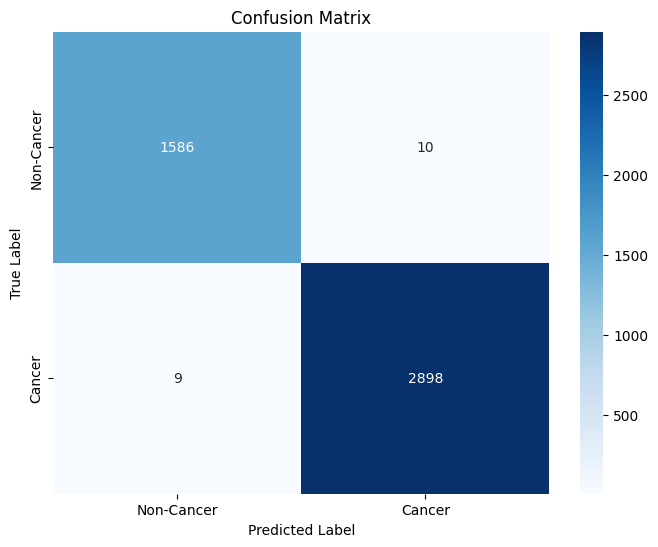

labeled_image_paths:  30020
Label: 30020
Metrics successfully saved to Excel


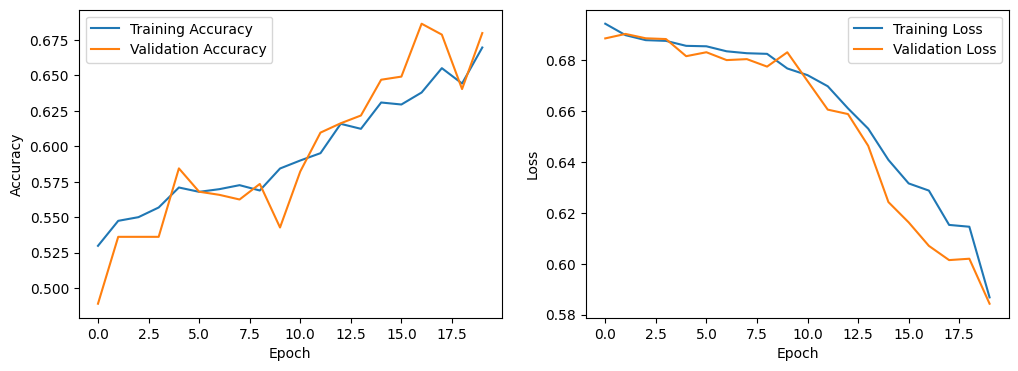

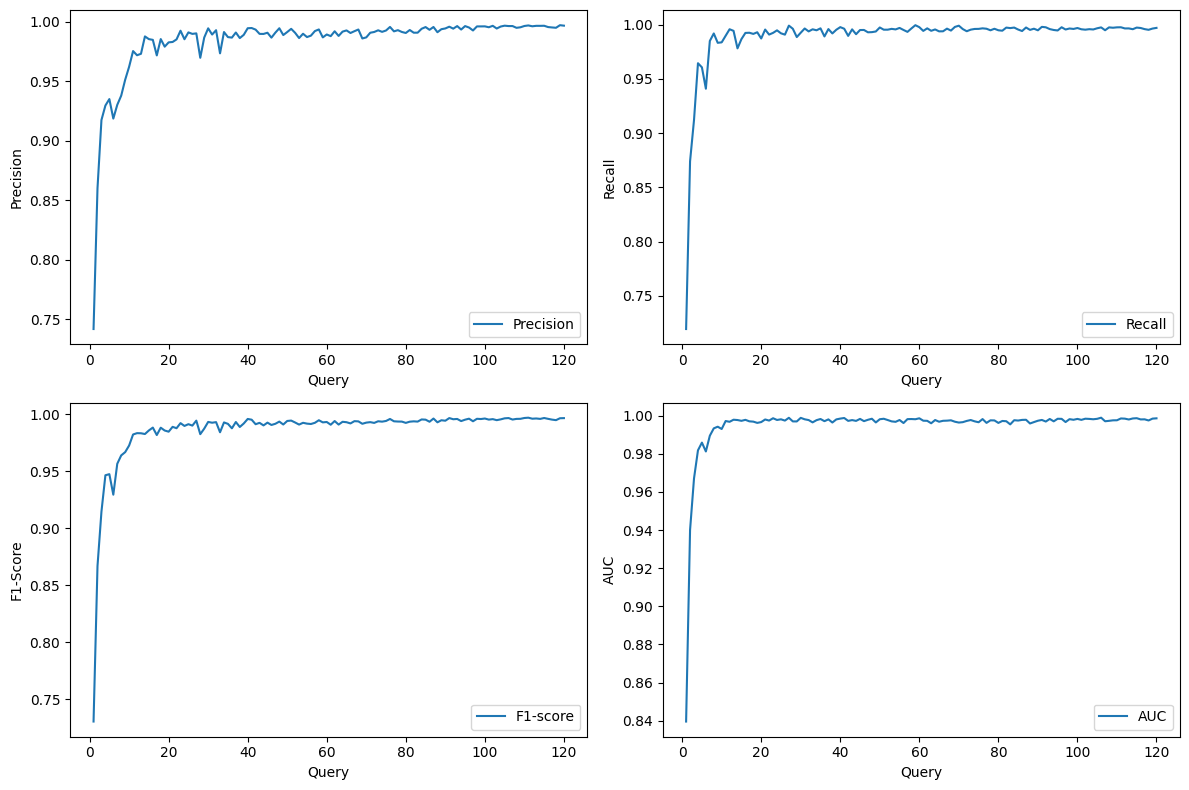

In [8]:

# Evaluate the final model on the test set after active learning
final_test_start_time = time.time()
final_test_accuracy = model.evaluate(X_test_labeled, y_test_labeled, verbose=0)[1]
final_test_predictions = model.predict(X_test_labeled)
final_test_predictions_binary = (final_test_predictions > 0.5).astype(int)
final_test_auc = roc_auc_score(y_test_labeled, final_test_predictions)
final_test_precision = precision_score(y_test_labeled, final_test_predictions_binary)
final_test_recall = recall_score(y_test_labeled, final_test_predictions_binary)
final_test_f1 = f1_score(y_test_labeled, final_test_predictions_binary)
final_test_time = time.time() - final_test_start_time

# Print final model performance on the testing set
print(f"Final Testing Accuracy: {final_test_accuracy:.4f}")
print(f"Final AUC: {final_test_auc:.4f}")
print(f"Final Precision: {final_test_precision:.4f}")
print(f"Final Recall: {final_test_recall:.4f}")
print(f"Final F1-Score: {final_test_f1:.4f}")
print(f"Final Testing Time: {final_test_time:.4f}s")

print('Length of y_test_labeled:', len(y_test_labeled))
print('Length of test_predictions_binary:', len(test_predictions_binary))
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_labeled, final_test_predictions_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Cancer', 'Cancer'],
            yticklabels=['Non-Cancer', 'Cancer'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
# Initialize an empty list to store the paths of labeled images
unlabeled_image_paths_to_save = unlabeled_image_paths
# Save the paths of labeled images with high entropy to an Excel file
unlabeled_paths_df = pd.DataFrame({'Image_Path': unlabeled_image_paths_to_save})  # Use unlabeled_image_paths_to_save
# Path to the Excel file to save the labeled images
unlabeled_excel_path = 'unlabeled_data_ALReinforcement.xlsx'
unlabeled_paths_df.to_excel(unlabeled_excel_path, index=False)

# Print the number of labeled and unlabeled images
print('labeled_image_paths: ', len(labeled_image_paths))
print('Label:', len(y_labeled))
# Save labeled data and metrics
labeled_paths_and_labels = {'path': labeled_image_paths, 'Label': y_labeled}
labeled_df = pd.DataFrame(labeled_paths_and_labels)
labeled_df.to_excel('labeled_data_ALReinforcement.xlsx', index=False)

query_numbers = list(range(1, len(active_learning_training_times) + 1))
# Define a function to pad lists
def pad_list(lst, length, value=None):
    return lst + [value] * (length - len(lst))


# Get the desired length (length of query_numbers)
desired_length = len(query_numbers)

# Pad or truncate lists
active_learning_training_times = pad_list(active_learning_training_times, desired_length)
train_precision_scores = pad_list(train_precision_scores, desired_length)
train_recall_scores = pad_list(train_recall_scores, desired_length)
train_auc_score = pad_list(train_auc_score, desired_length)
train_f1_scores = pad_list(train_f1_scores, desired_length)
active_learning_validation_times = pad_list(active_learning_validation_times, desired_length)
val_auc_scores = pad_list(val_auc_scores, desired_length)
val_accuracy_scores = pad_list(val_accuracy_scores, desired_length)
val_precision_scores = pad_list(val_precision_scores, desired_length)
val_recall_scores = pad_list(val_recall_scores, desired_length)
val_f1_scores = pad_list(val_f1_scores, desired_length)
active_learning_testing_times = pad_list(active_learning_testing_times, desired_length)
test_accuracy_scores = pad_list(test_accuracy_scores, desired_length)
test_auc_score = pad_list(test_auc_score, desired_length)
test_precision_scores = pad_list(test_precision_scores, desired_length)
test_recall_scores = pad_list(test_recall_scores, desired_length)
test_f1_scores = pad_list(test_f1_scores, desired_length)

# Ensure lists are populated and not empty
metrics_data = {
    'Query number': query_numbers,
    'Training Time': active_learning_training_times,
    'Train Precision': train_precision_scores,
    'Train Recall': train_recall_scores,
    'Train AUC': train_auc_score,
    'Train F1 Score': train_f1_scores,
    'Validation Time': active_learning_validation_times,
    'Validation AUC': val_auc_scores,
    'Validation Accuracy': val_accuracy_scores,
    'Validation Precision': val_precision_scores,
    'Validation Recall': val_recall_scores,
    'Validation F1 Score': val_f1_scores,
    'Testing Time': active_learning_testing_times,
    'Test Accuracy': test_accuracy_scores,
    'Test AUC': test_auc_score,
    'Test Precision': test_precision_scores,
    'Test Recall': test_recall_scores,
    'Test F1 Score': test_f1_scores
}

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Check if DataFrame is not empty before saving
if not metrics_df.empty:
    metrics_df.to_excel('metrics_AL_entropy.xlsx', index=False)
    print("Metrics successfully saved to Excel")

# Optionally test writing to CSV
# metrics_df.to_csv('D:/PHD/DSB3/stage1/stage1/metrics_AL_entropy_test.csv', index=False)
# metrics_df.to_excel('D:/PHD/DSB3/stage1/stage1/metrics_AL_entropy.xlsx', index=False)

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Save the final Q-table
np.save('Q_table.npy', dict(Q_table))
# Convert the Q_table dictionary to a list of tuples for DataFrame creation
Q_table_list = [(state, action, value) for state, actions in Q_table.items() for action, value in enumerate(actions)]
# Convert the Q_table list to a DataFrame
df_array = pd.DataFrame(Q_table_list, columns=['State', 'Action', 'Value'])
# Save the DataFrame to an Excel file
df_array.to_excel('Q_table.xlsx', index=False)

# Plot the final performance metrics
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(range(1, len(test_precision_scores) + 1), test_precision_scores, label='Precision')
plt.xlabel('Query')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 2, 2)
# plt.plot(range(1, n_queries + 1), recall_scores, label='Recall')
plt.plot(range(1, len(test_recall_scores) + 1), test_recall_scores, label='Recall')
plt.xlabel('Query')
plt.ylabel('Recall')
plt.legend()

plt.subplot(2, 2, 3)
# plt.plot(range(1, n_queries + 1), f1_scores, label='F1-Score')
plt.plot(range(1, len(test_f1_scores) + 1), test_f1_scores, label='F1-score')
plt.xlabel('Query')
plt.ylabel('F1-Score')
plt.legend()

plt.subplot(2, 2, 4)
# plt.plot(range(1, n_queries + 1), active_learning_auc, label='AUC')
plt.plot(range(1, len(test_auc_score) + 1), test_auc_score, label='AUC')
plt.xlabel('Query')
plt.ylabel('AUC')
plt.legend()
plt.tight_layout()
plt.show()

SyntaxError: invalid syntax (2272728702.py, line 1)